In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import NMF

from playervectors import PlayerHeatMap
from ExtractData import ExtractCoordinates, ExtractPlayers, ExtractTeams, ExtractMinutesPlayed, ExtractGoalkeepers, CalcPlayingDirection, NormalizeDirection

## Load: Players

In [2]:
df_players = pd.read_csv('event_streams/players.csv')
df_players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,NaN,Tekin,4502.0,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687.0
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,NaN,Sarr,3775.0,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423.0
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,NaN,Mandanda,3772.0,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,NaN,O. Mandanda,NaN
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,NaN,N'Diaye,683.0,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314.0
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,NaN,Konat\u00e9,2975.0,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,NaN


#### Extract Player Information

In [3]:
# Mapping {playerID -> [list of selected attributes]}
players = ExtractPlayers(df=df_players, wy_id='wyId', attributes=['firstName', 'lastName', 'currentTeamId'])

In [4]:
df_playerank = pd.read_csv('event_streams/playerank.csv')
df_playerank.head()

,goalScored,playerankScore,matchId,playerId,roleCluster,minutesPlayed
0,0,0.0053,2057991,10014,right CB,90
1,0,0.0009,2057992,10014,right CB,41
2,0,-0.0013,2057998,100140,central MF,90
3,0,0.0031,2058000,100140,left CB,90
4,0,0.0035,2499869,10108,right CB,90


#### Extract Goalkeepers

In [5]:
keepers = ExtractGoalkeepers(df_players, wy_code='name', keeper_str='Goalkeeper')

#### Extract Played Minutes

In [6]:
# Extract played minutes
# Mapping {playerID -> minutes}
minutes_played = ExtractMinutesPlayed(df=df_playerank, column_player='playerId', column_minutes='minutesPlayed')

## Load: Event Streams

In [7]:
df_events = pd.read_csv('event_streams/actions.csv')
df_events.head()

,Unnamed: 0,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name
0,0,2500089,1,2.763597,1659,9637,52.50,34.00,63.00,30.60,251700146.0,0,0,1,0,pass,success,foot
1,1,2500089,1,4.761353,1659,8351,63.00,30.60,64.05,10.20,251700147.0,0,0,1,1,pass,success,foot
2,2,2500089,1,5.533097,1659,9285,64.05,10.20,72.45,20.40,251700148.0,0,0,1,2,pass,success,foot
3,3,2500089,1,7.707561,1659,239411,72.45,20.40,35.70,19.04,251700161.0,0,0,1,3,pass,success,foot
4,4,2500089,1,11.614943,1659,9637,35.70,19.04,30.45,12.24,251700149.0,0,0,1,4,pass,success,foot


In [8]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462726 entries, 0 to 2462725
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   game_id            int64  
 2   period_id          int64  
 3   time_seconds       float64
 4   team_id            int64  
 5   player_id          int64  
 6   start_x            float64
 7   start_y            float64
 8   end_x              float64
 9   end_y              float64
 10  original_event_id  float64
 11  bodypart_id        int64  
 12  type_id            int64  
 13  result_id          int64  
 14  action_id          int64  
 15  type_name          object 
 16  result_name        object 
 17  bodypart_name      object 
dtypes: float64(6), int64(9), object(3)
memory usage: 338.2+ MB


#### Normalize Playing Direction

In [9]:
df_events['start_x'] = 100 - df_events['start_x']
df_events['start_y'] = 100 - df_events['start_y']

#### Select Relevant Actions with respect to thier x,y coordinates

In [10]:
# {action -> {playerID -> ([list of x coordinates], [list of y coordinates])}}
coordinates = ExtractCoordinates(df=df_events, column_player_id='player_id', column_event_name='type_name', column_x='start_x', column_y='start_y', actions=['pass', 'cross', 'shot', 'dribble'])

## Load: Teams

In [11]:
df_teams = pd.read_csv('event_streams/teams.csv')
df_teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


#### Extract Team Information

In [12]:
# Extracting Team Information
# Mapping {teamID -> [selected attributes e.g. TeamName, City, ...]}
teams = ExtractTeams(df=df_teams, wy_id='wyId', attributes=['name'])

In [13]:
# Mapping {teamID -> [list of playerIDs]}
teamID_to_playerIDs = {}

# Mapping {playerID -> Player Name}
playersID_to_name = {}

for playerID, attributes in players.items():
    first, last, teamID = attributes[0], str(attributes[1]), str(attributes[2])
    
    if teamID not in teamID_to_playerIDs:
        teamID_to_playerIDs[teamID] = [playerID]
    else:
        teamID_to_playerIDs[teamID].append(playerID)
    
    if playerID not in playersID_to_name:
        playersID_to_name[playerID] = f'{first} {last}'

## Building Player Vectors

### 1. Selecting Relevant Action Types
In the paper, they set k_t as the minimal number of components needed to explain
70% of the variance in the heatmaps of action type t. This parameter setting
was empirically found to work well because of the high variability of players’
positions in their actions (see Challenge 1 in Section 2).

Ignoring 30% of the variance allows us to summarize a player’s playstyle only by his dominant regions
on the field rather than model every position on the field he ever occupied.

This design choice lead to use 4 shot components, 4 cross components, 5 dribble
components, and 5 pass components, adding up to form length-18 player vectors 

### 2. Constructing Heatmaps

* 2.1 Counting

* 2.2 Normalizing

* 3.3 Smoothing

In [14]:
# ------------------------------------------------------
# 2. Constructing Heatmaps

# ------------------------------------------------------
# Hyperparameters:
grid = (50, 50)                                 # Grid dimensions
sigma = 7.0                                     # Sigma for gaussian blur
actions = ['shot', 'cross', 'dribble', 'pass']  # Relevant actions
components = [4, 4, 5, 5]                       # Components for actions: 4 + 4 + 5 + 5 = 18 components
init_nmf = 'nndsvd'                             # NMF initialization parameter
random_nmf = 42                                 # NMF random sate
loss_nmf = 'frobenius'                          # NMF loss
verbose = True                                  # Printing parameter

# Mapping of player IDs to a list of heatmaps for their respective actions
# i.e. 43 -> [heatmap_shot, heatmap_cross, heatmap_dribble, heatmap_pass], 54 -> [heatmap_shot, ...]
player_heatmaps = {}
for action in actions:
    for playerID, coordinates_xy in list(coordinates[action].items()):
        if playerID not in player_heatmaps:
            player_heatmaps[playerID] = [] 
        
        x, y = coordinates_xy[0], coordinates_xy[1] 

        # Check for played minutes 
        minutes = 0.0 
        if playerID in minutes_played: 
            minutes = minutes_played[playerID] 

        # Check for player name
        player_name = None
        if playerID in playersID_to_name:
            player_name = playersID_to_name[playerID]

        # Build Player-Vectors
        heatmap = PlayerHeatMap(shape=grid,
                                player_name=player_name,
                                player_id=playerID,
                                action_name=action,
                                sigma=sigma,
                                map_size=[[0, 100], [0, 100]])

        # 1 - 3: Counting + Normalizing + Smoothing
        heatmap.fit(x, y, minutes)
        player_heatmaps[playerID].append(heatmap.heatmap_)

### 3. Compressing Heatmaps to Vectors

* 3.1 Reshaping

* 3.2 Construct the matrix M

* 3.3 Compress matrix M by applying non-negative matrix factorization (NMF)

In [15]:
# ------------------------------------------------------
# (3): Compressing Heatmaps to Vectors

# Mapping each action type to its corresponding matrix (M_action)
# i.e. shot -> M_shot, cross -> M_cross, dirbble -> M_dribble, pass -> M_pass
action_to_matrix = {action: [] for action in actions}

# Store corresponding player IDs
# i.e. shot -> [34, 234, 232, ... list of player_ids for action shot], cross -> [454, 643, ...]
action_to_player = {action: [] for action in actions}

# (3.1): Reshaping
for playerID, list_heatmaps in player_heatmaps.items():
    num_players = len(player_heatmaps)
    
    # list_heatmaps of structure: [heatmap_shot, heatmap_cross, heatmap_dribble, heatmap_pass]
    for action_index, X in enumerate(list_heatmaps):
        # Reshaping heatmap of shape (m, n) to vector of shape (n * m, 1) 
        X_reshape = X.reshape(grid[0] * grid[1], 1)
        
        # Store reshaped heatmap and corresponding player ID
        action_to_matrix[actions[action_index]].append(X_reshape)
        
        # Save corresponding player_ids
        action_to_player[actions[action_index]].append(playerID)

# (3.2): Construction of matrix M:
for action in action_to_matrix:
    M = np.array(action_to_matrix[action])
    M = M.reshape(grid[0] * grid[1], len(M))
    action_to_matrix[action] = M

In [16]:
# -----------------------------------------------------------------------------
# (3.3): Compress matrix M by applying non-negative matrix factorization (NMF)
# -----------------------------------------------------------------------------

# Dictionary to store the resulting feature vectors for each action type
# i.e. shot -> []
actions_to_vectors = {}
for i, (action, M) in enumerate(action_to_matrix.items()):
    # Suppress all convergence warnings from sklearn
    warnings.filterwarnings("ignore", category=UserWarning) 
    
    # Apply NMF to compress the heatmap matrix M into lower-dimensional space
    model = NMF(n_components=components[i], init=init_nmf, random_state=random_nmf, max_iter=500) 

    # Factorizing M: M ≈ W @ H
    W = model.fit_transform(M)
    H = model.components_

    principal_vector = np.split(H, H.shape[1], axis=1) 
    actions_to_vectors[action] = principal_vector

    if verbose:
        print(f'Action: {action}\tShape of M: {M.shape}\tShape of W: {W.shape}\tShape of H: {H.shape}')

Action: shot	Shape of M: (2500, 3030)	Shape of W: (2500, 4)	Shape of H: (4, 3030)
Action: cross	Shape of M: (2500, 2920)	Shape of W: (2500, 4)	Shape of H: (4, 2920)
Action: dribble	Shape of M: (2500, 2538)	Shape of W: (2500, 5)	Shape of H: (5, 2538)
Action: pass	Shape of M: (2500, 2155)	Shape of W: (2500, 5)	Shape of H: (5, 2155)


### 4. Assembling Player Vectors

In [17]:
# ------------------------------------------------------
# (4): Assemble Player Vectors

# Mapping player'ids to corresponding 18-component player vector
player_to_vector = {}

for action, princ_vectors in actions_to_vectors.items():
    for i, vector in enumerate(princ_vectors):
        playerID = action_to_player[action][i]
        if playerID not in player_to_vector:
            player_to_vector[playerID] = []
        player_to_vector[playerID].extend(vector.flatten())

/var/folders/63/8txvxcxn749f_382tm389wwm0000gn/T/ipykernel_27452/1807797476.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


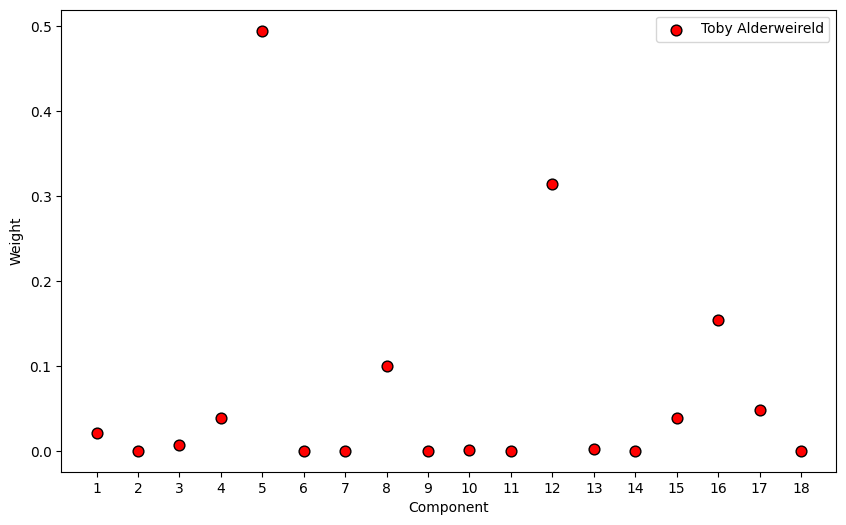

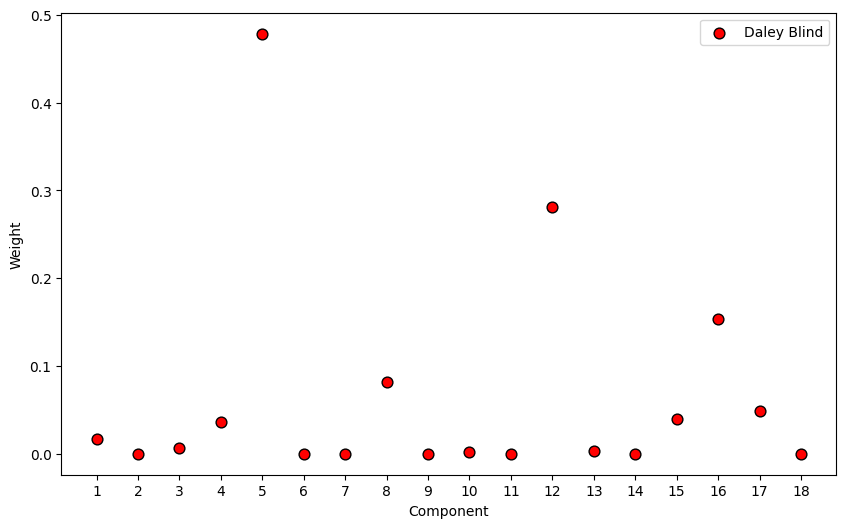

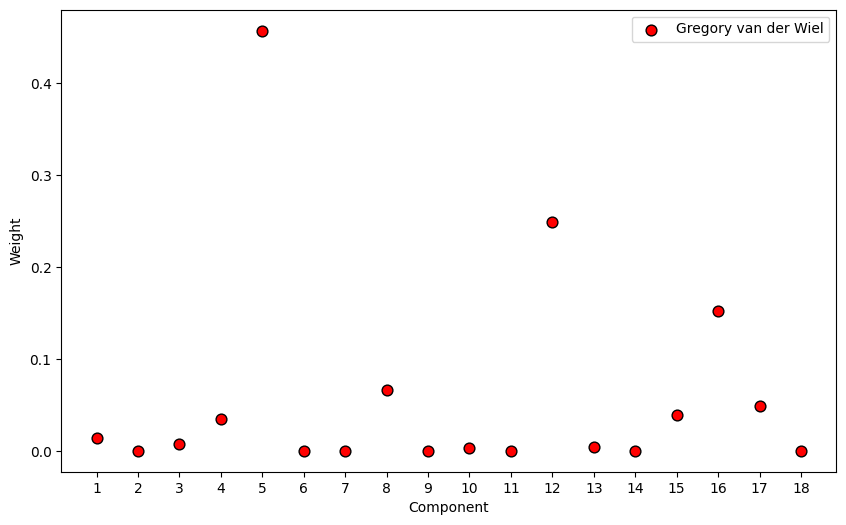

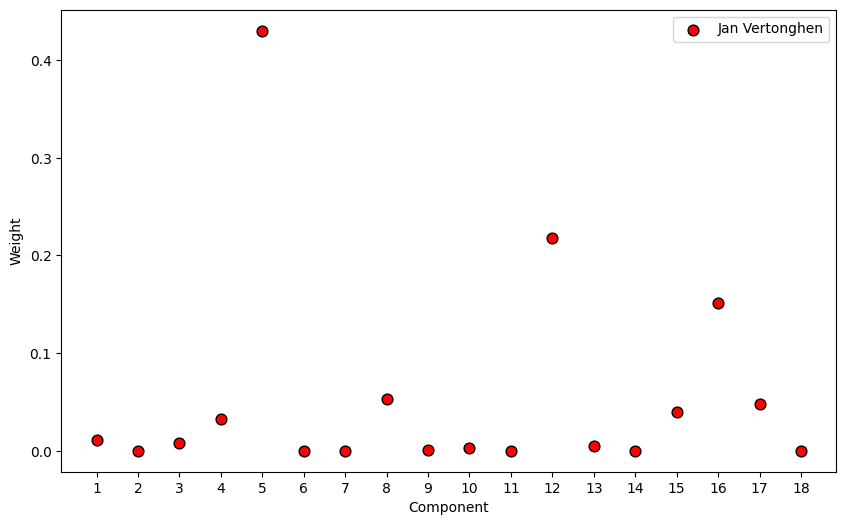

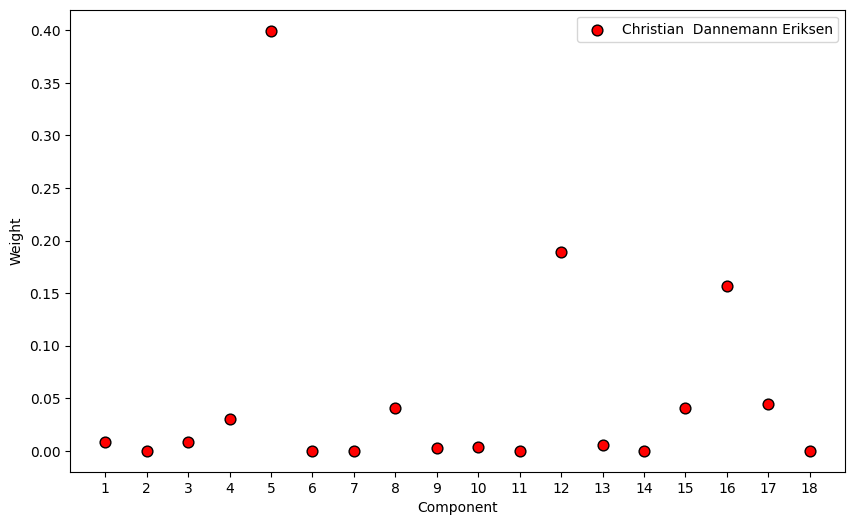

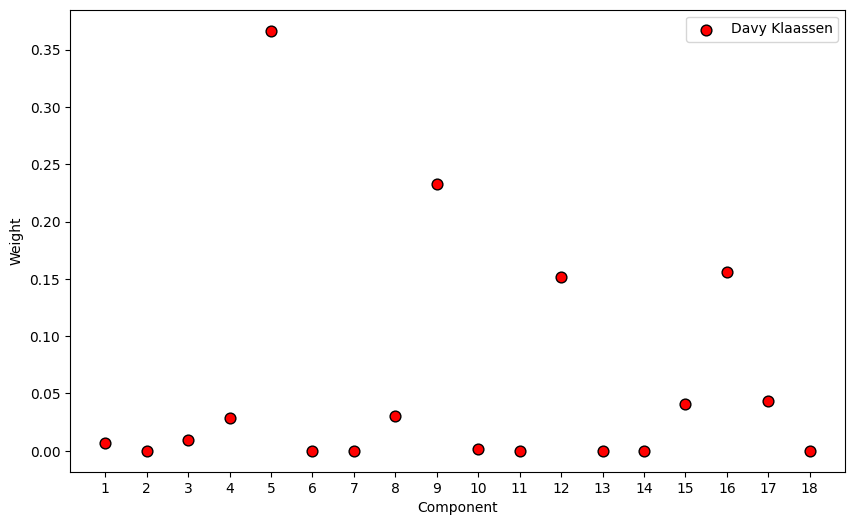

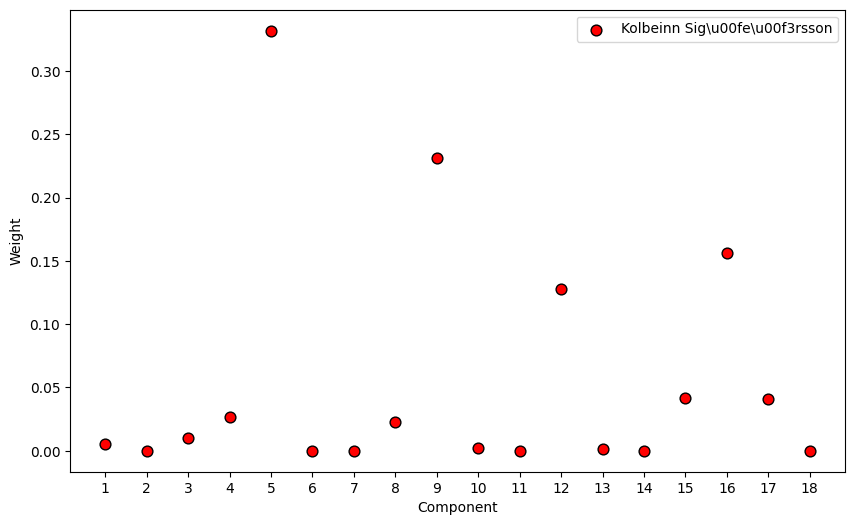

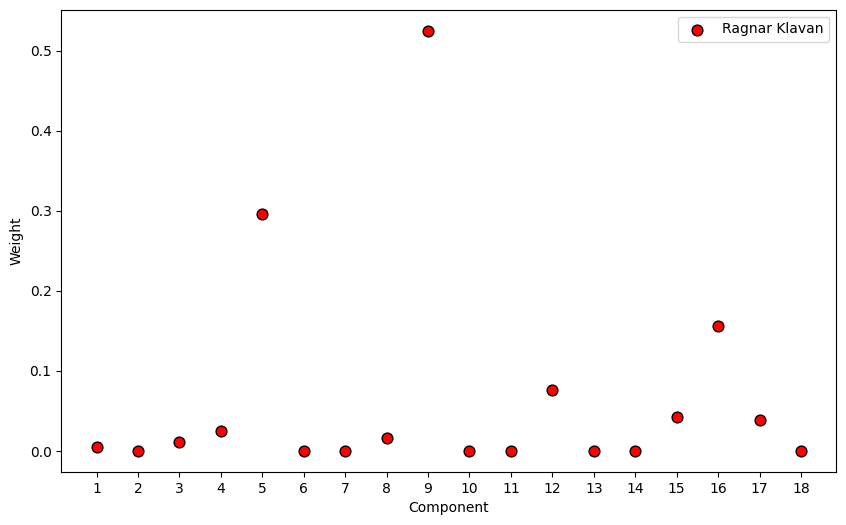

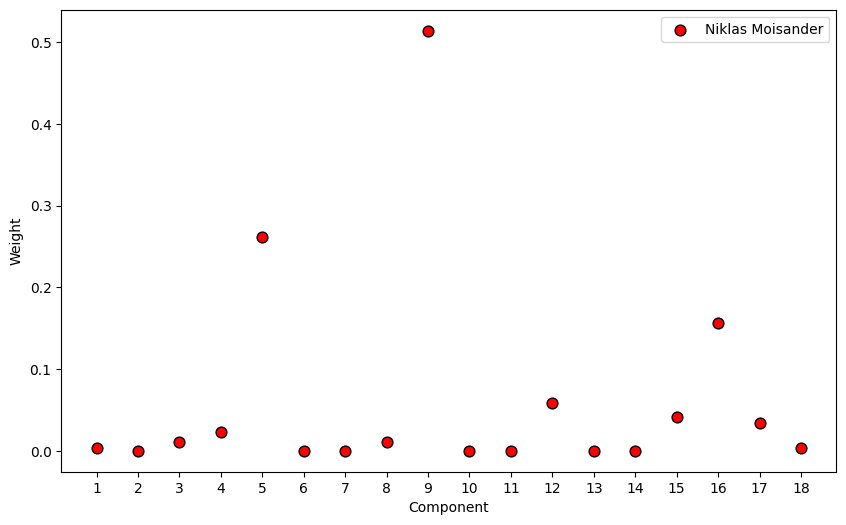

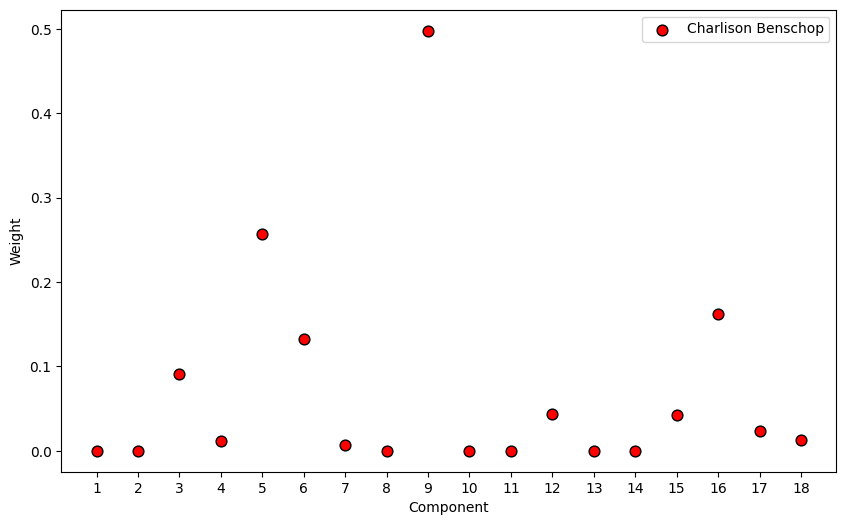

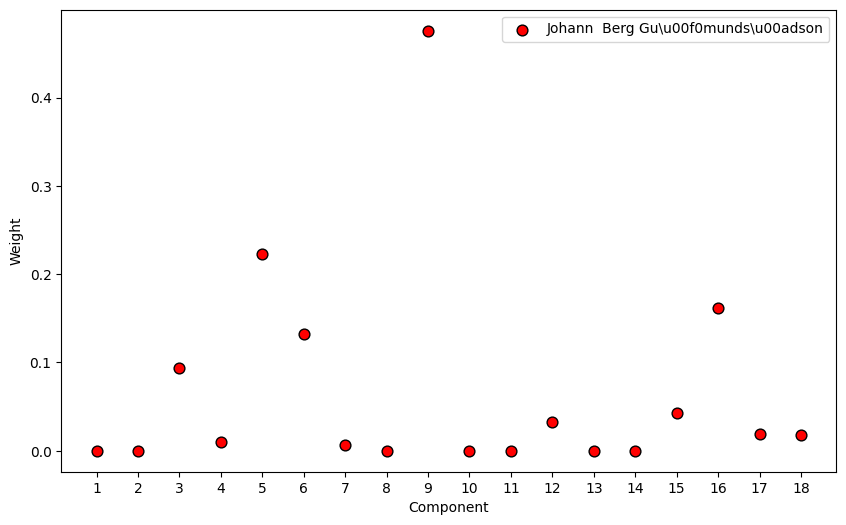

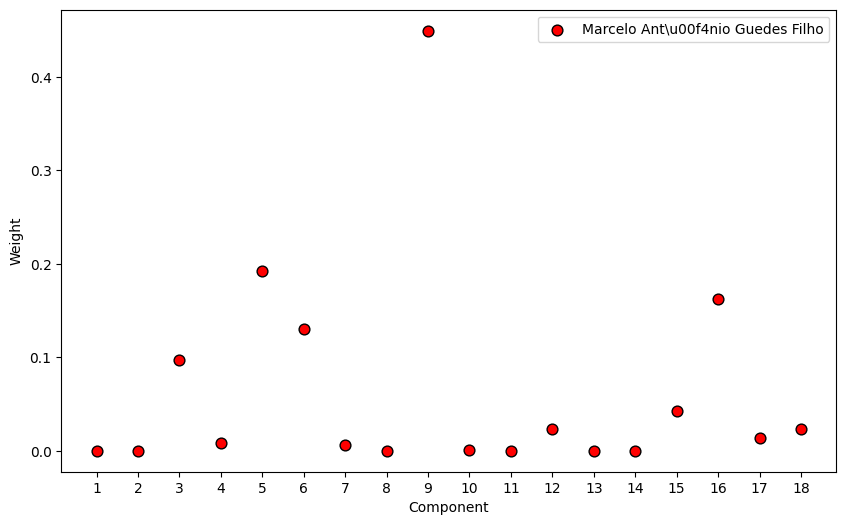

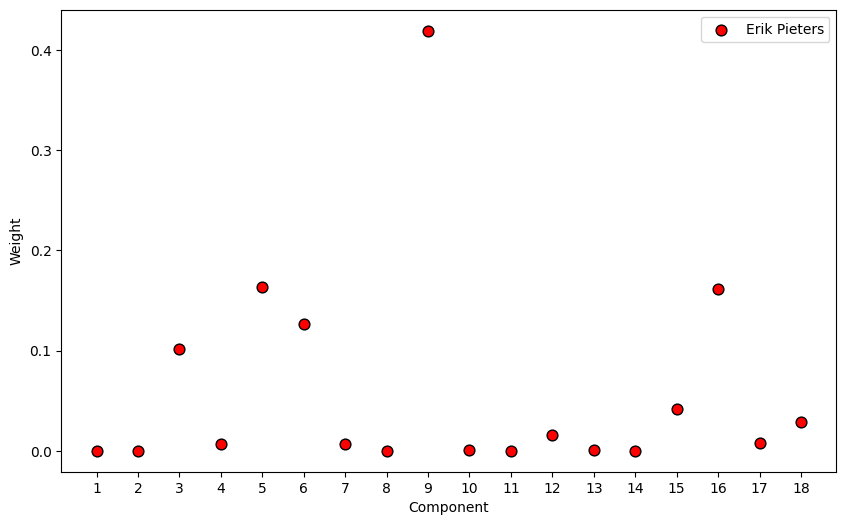

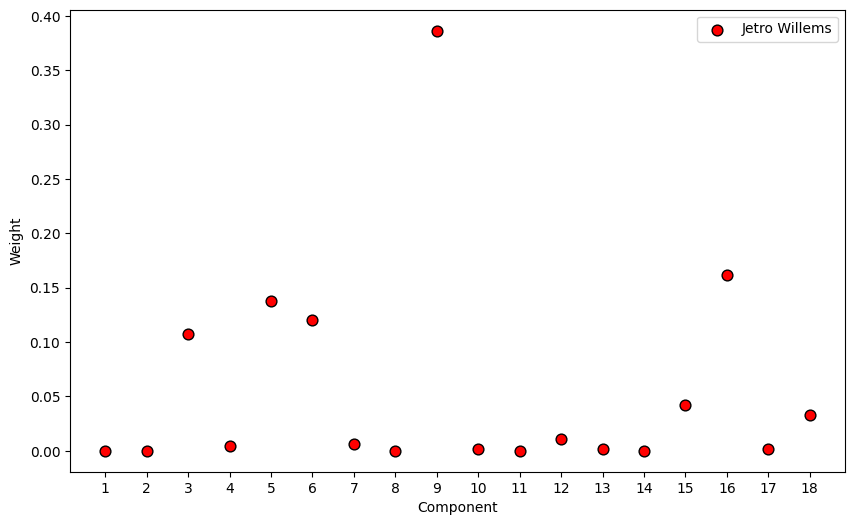

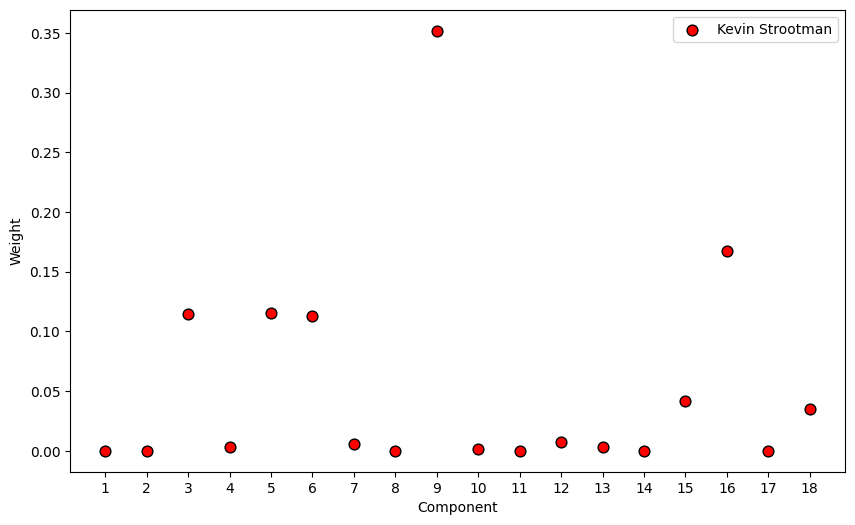

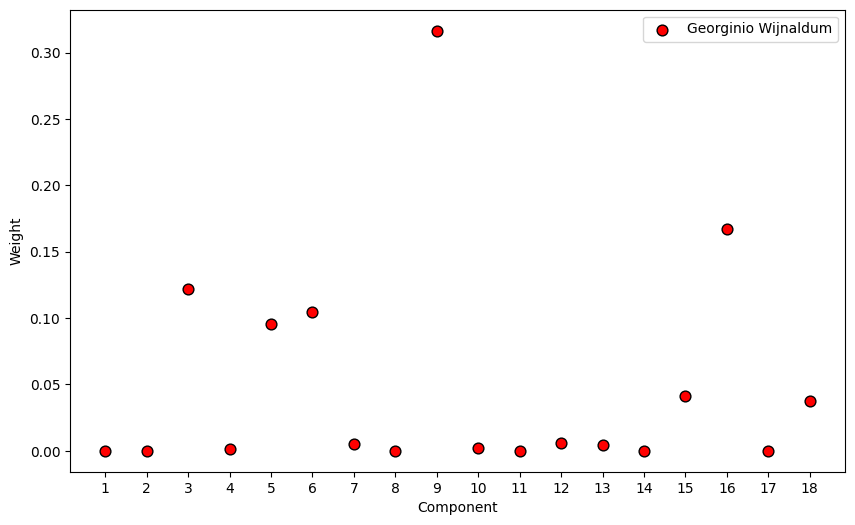

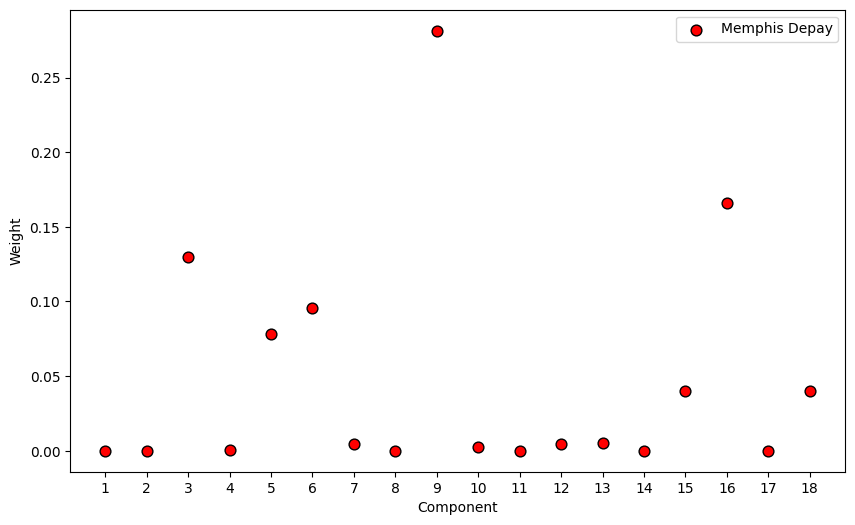

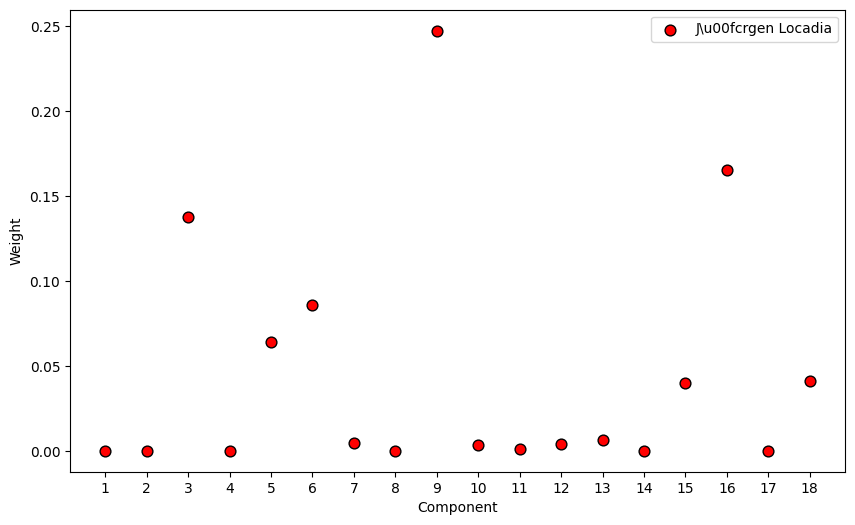

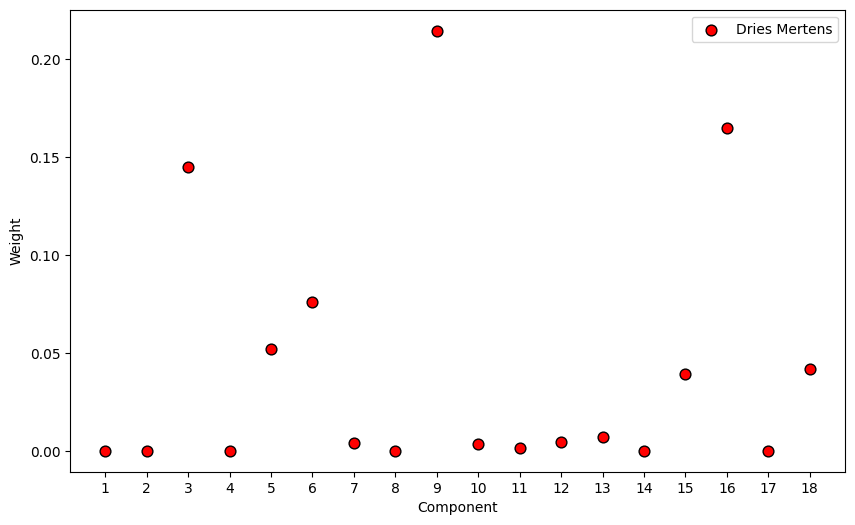

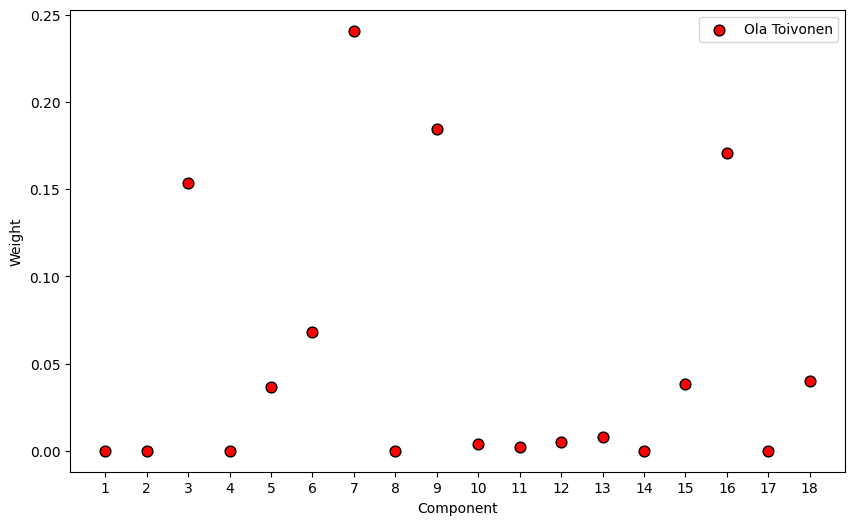

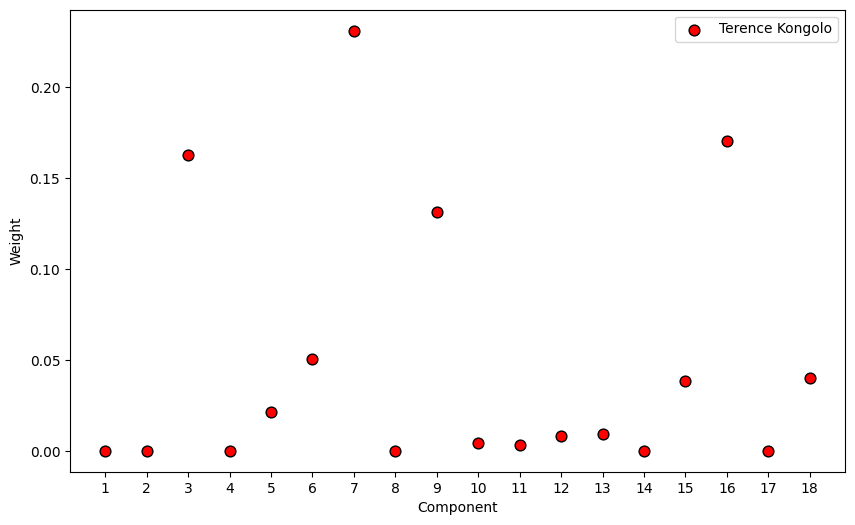

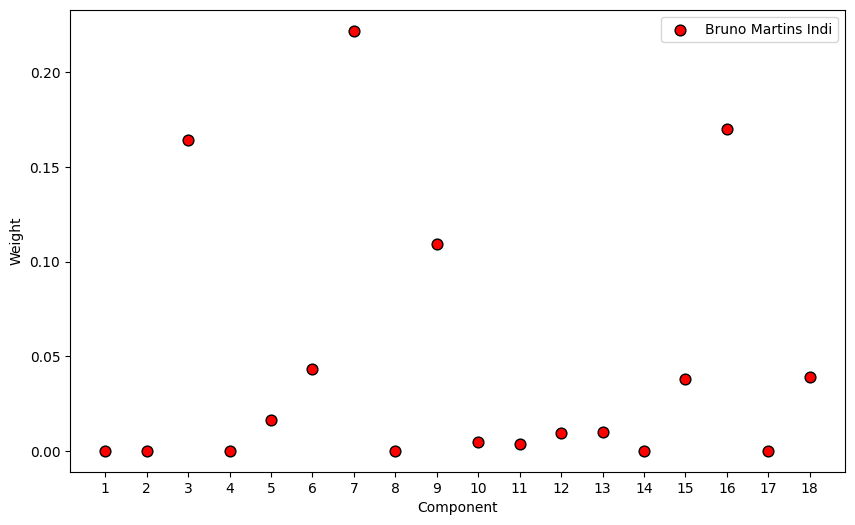

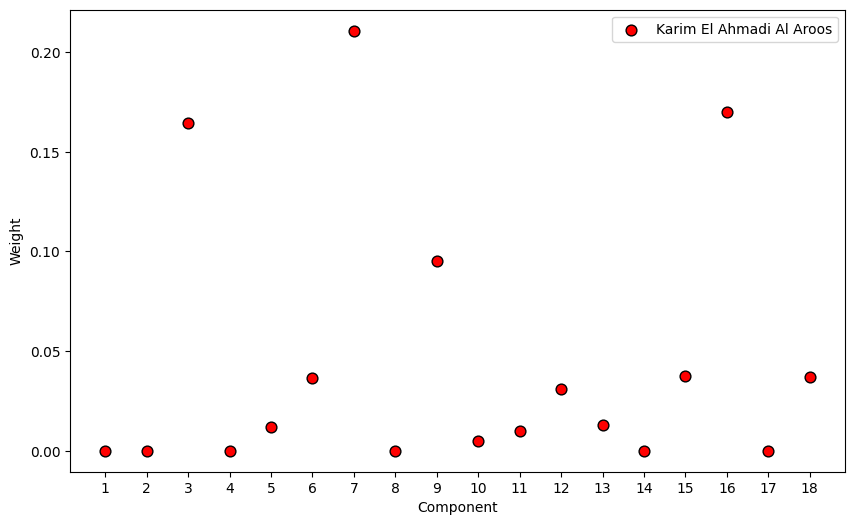

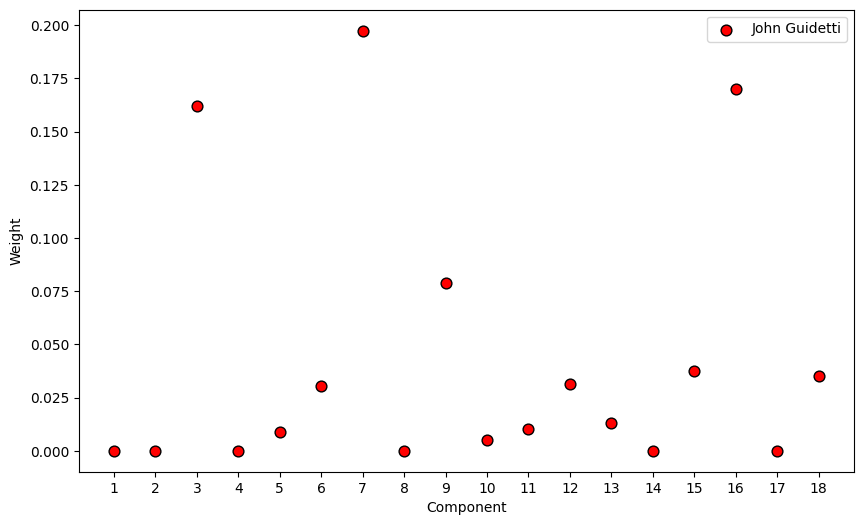

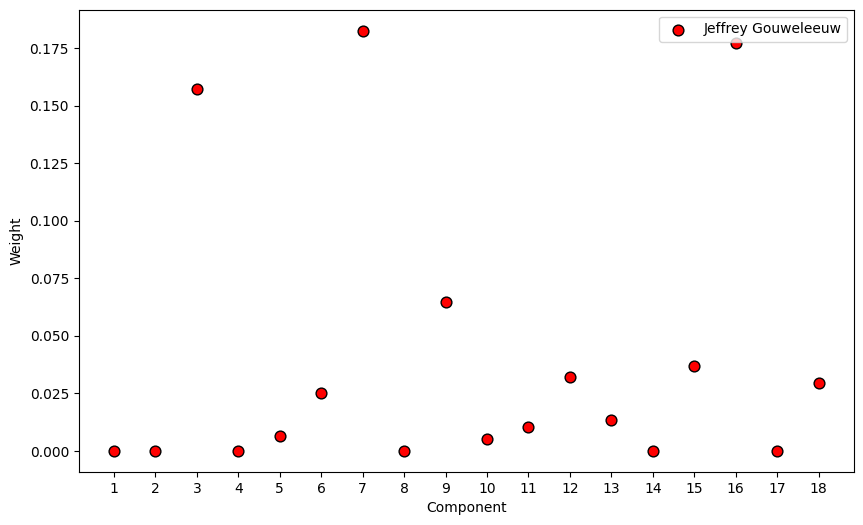

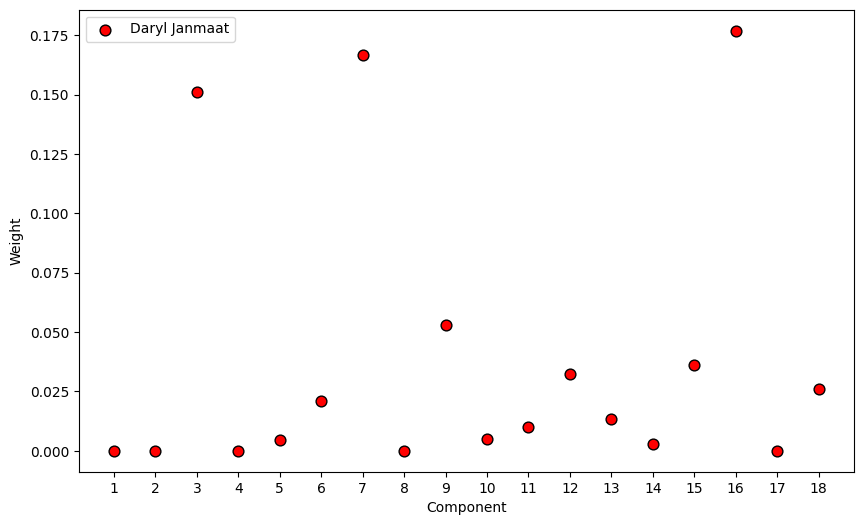

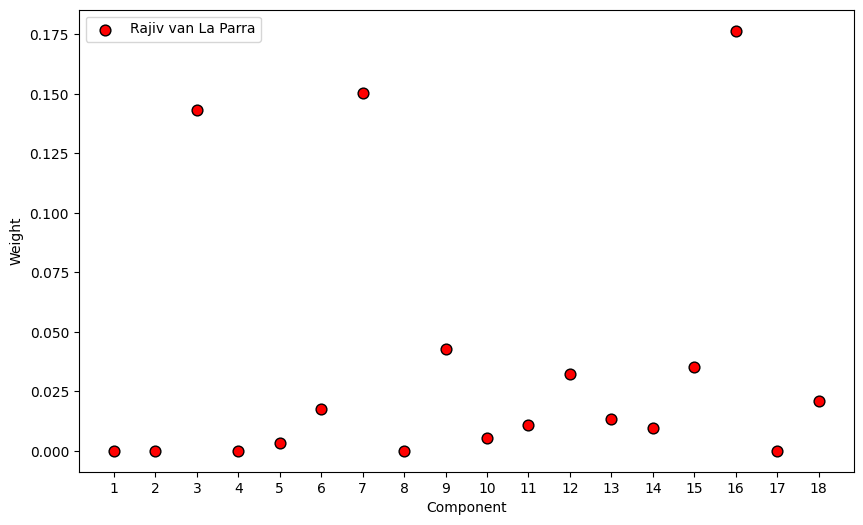

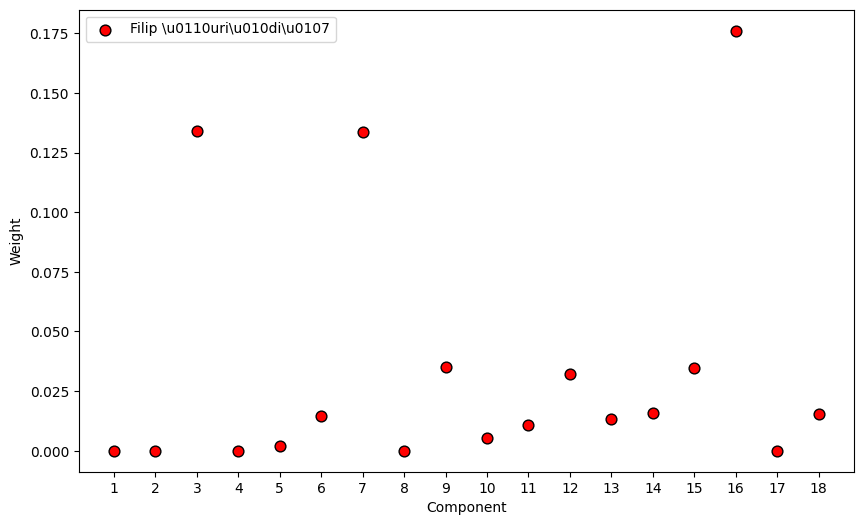

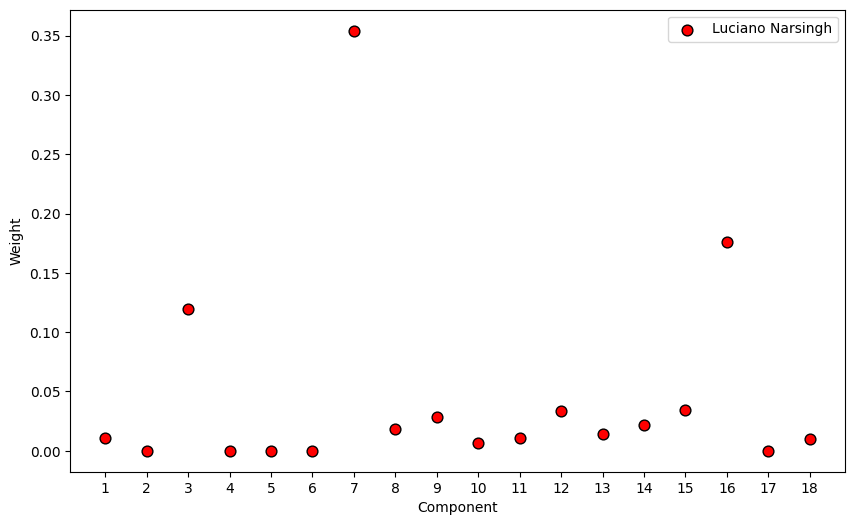

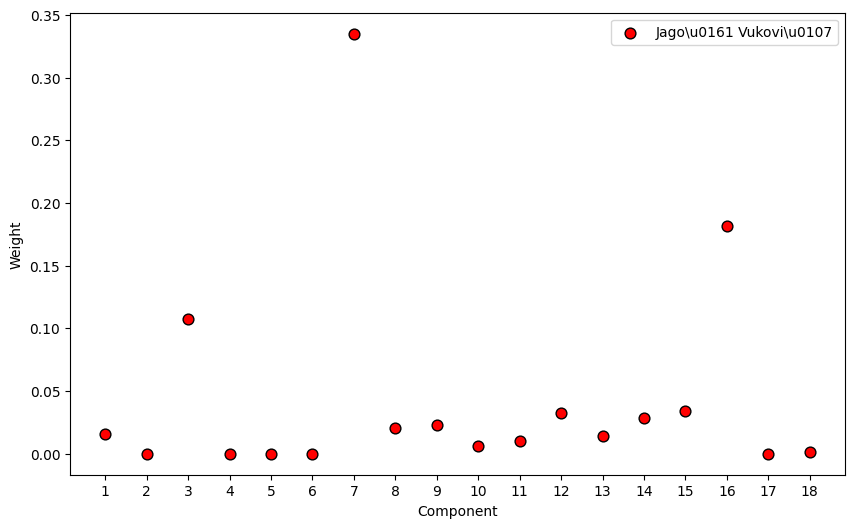

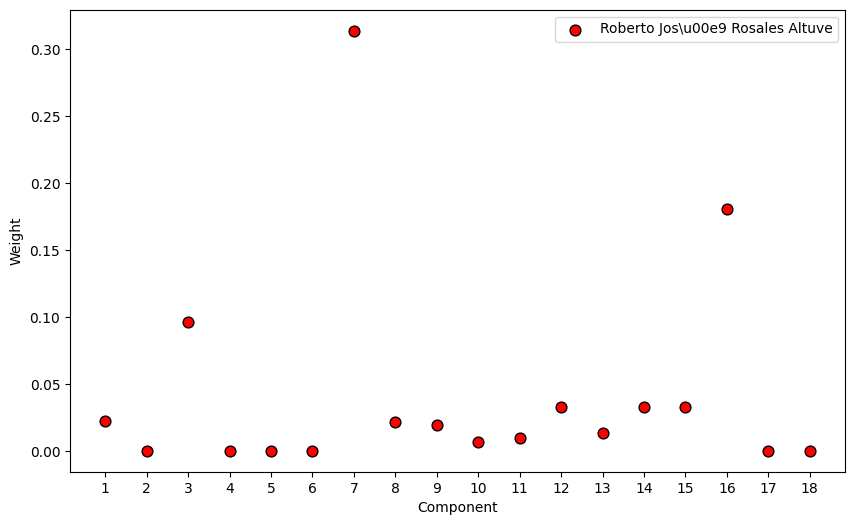

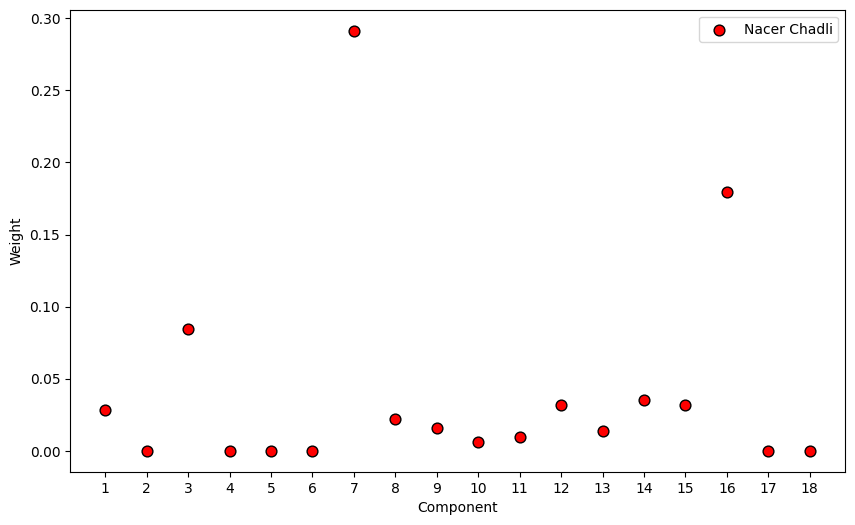

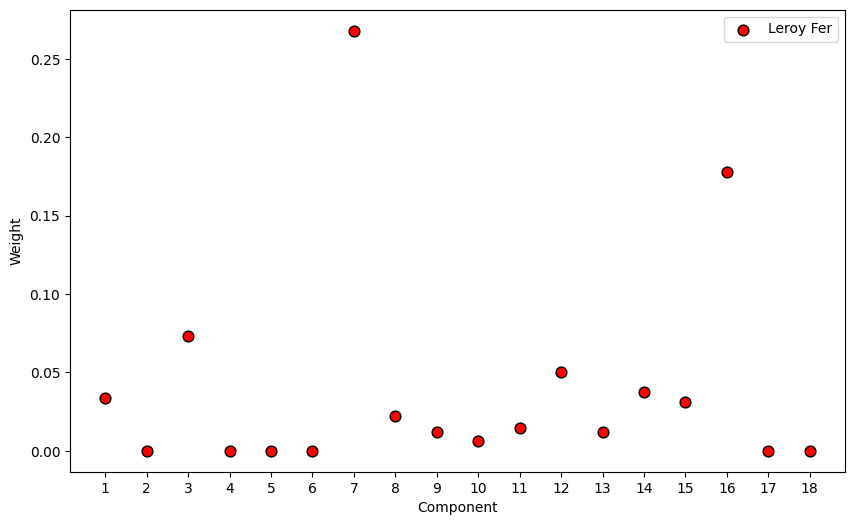

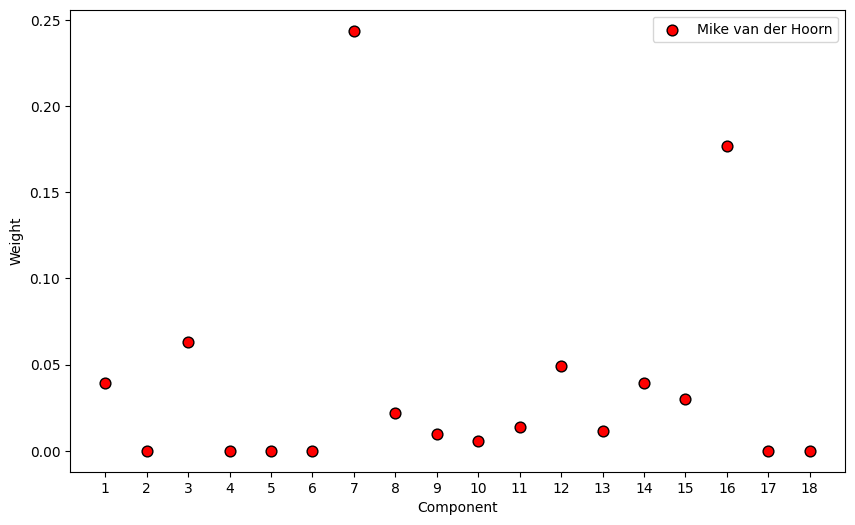

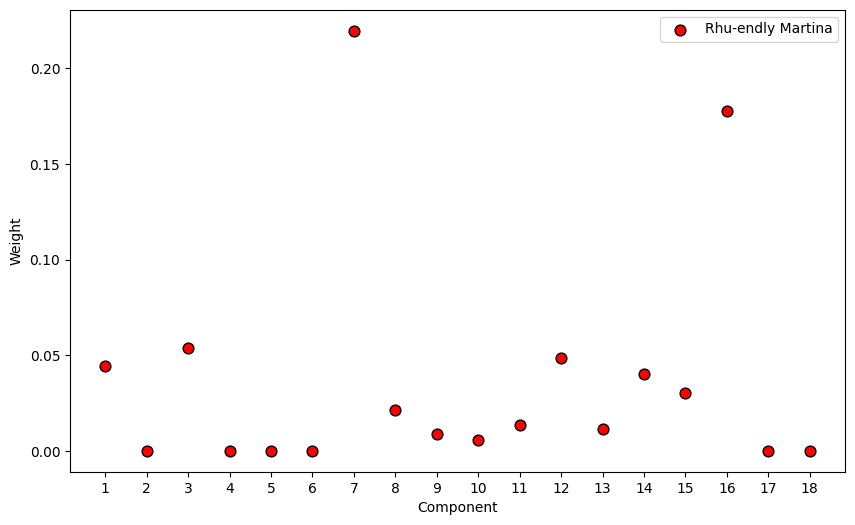

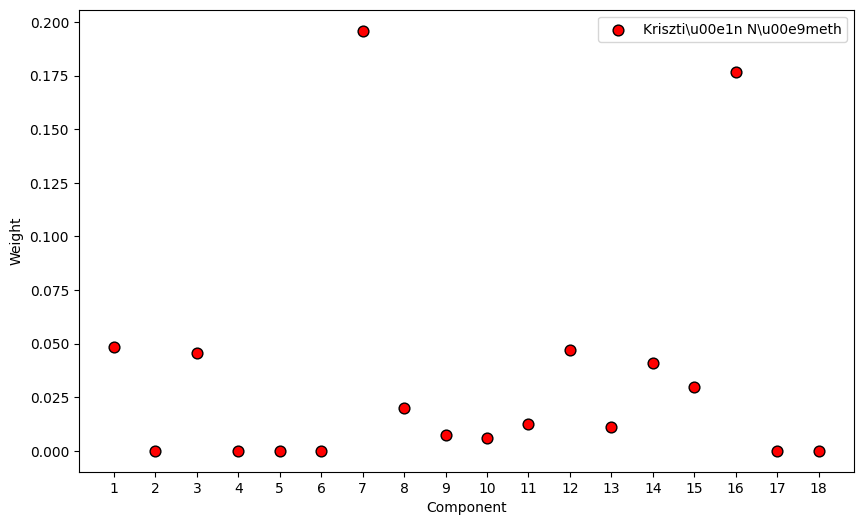

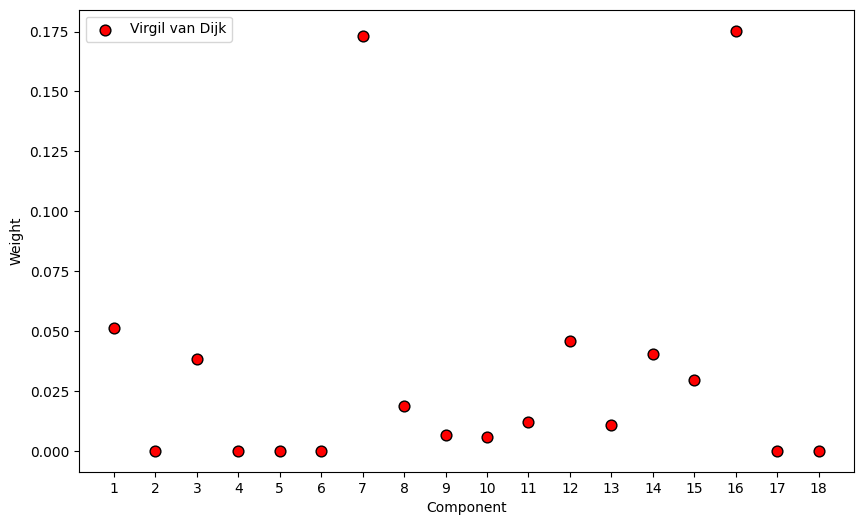

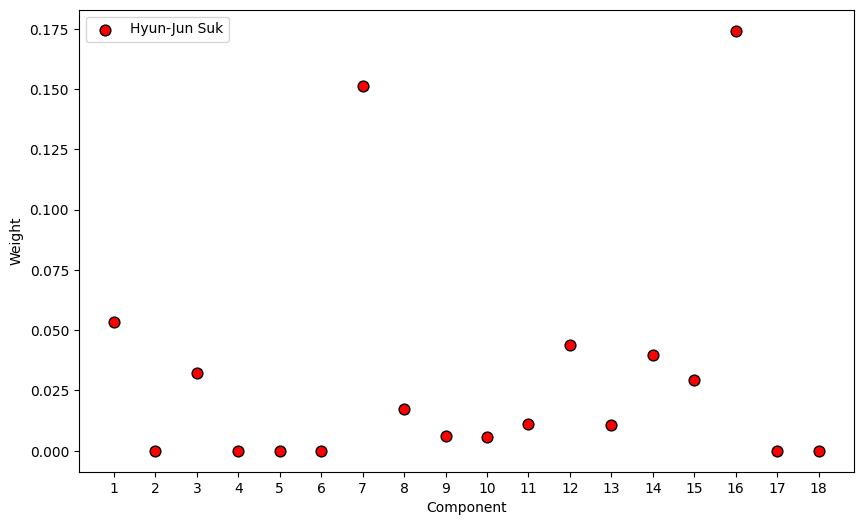

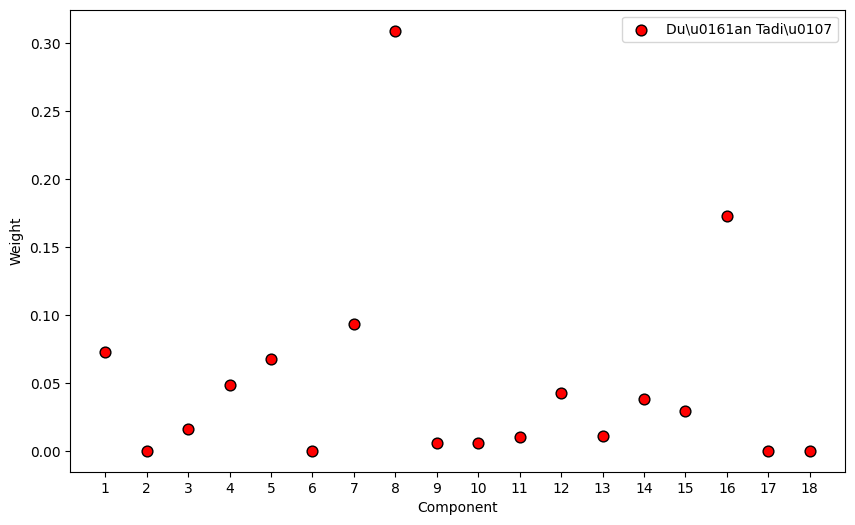

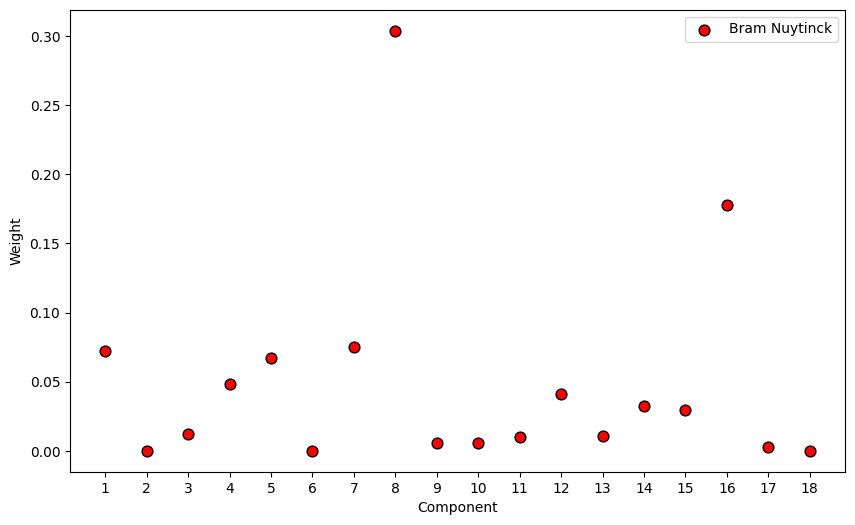

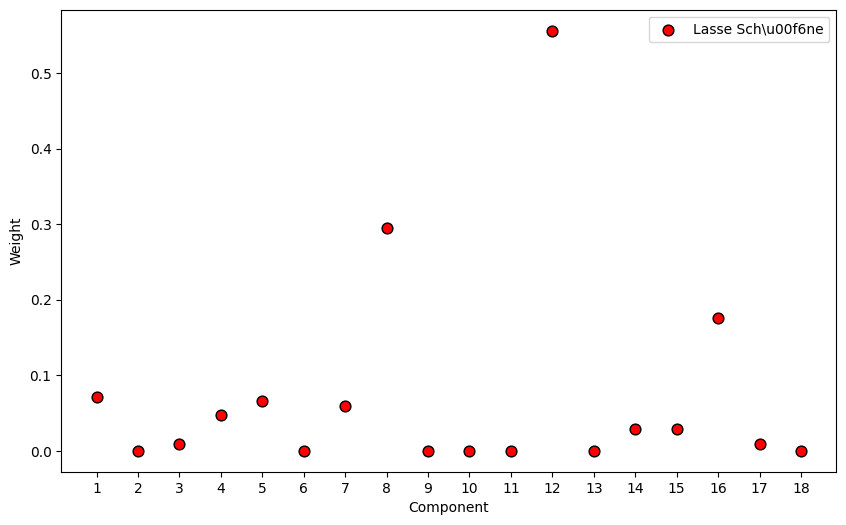

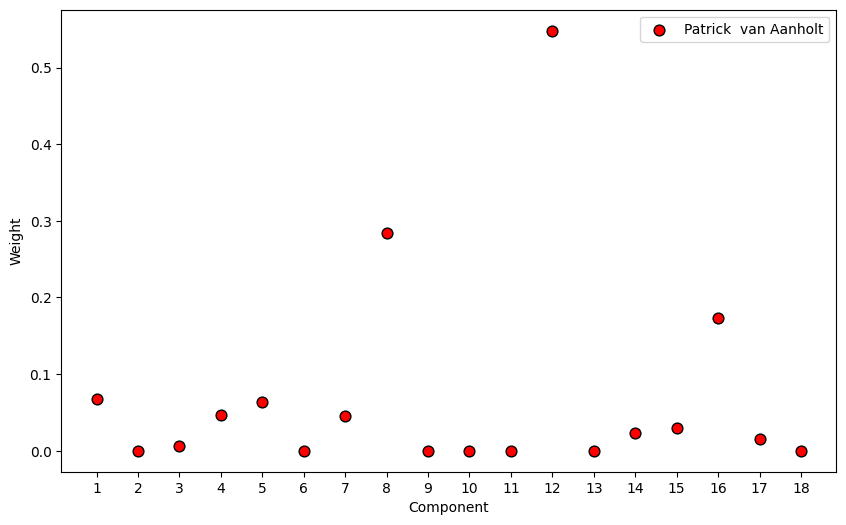

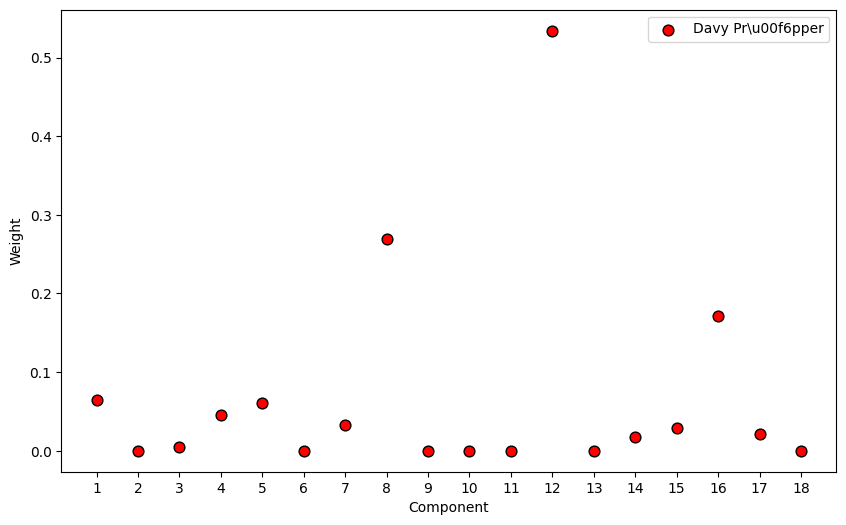

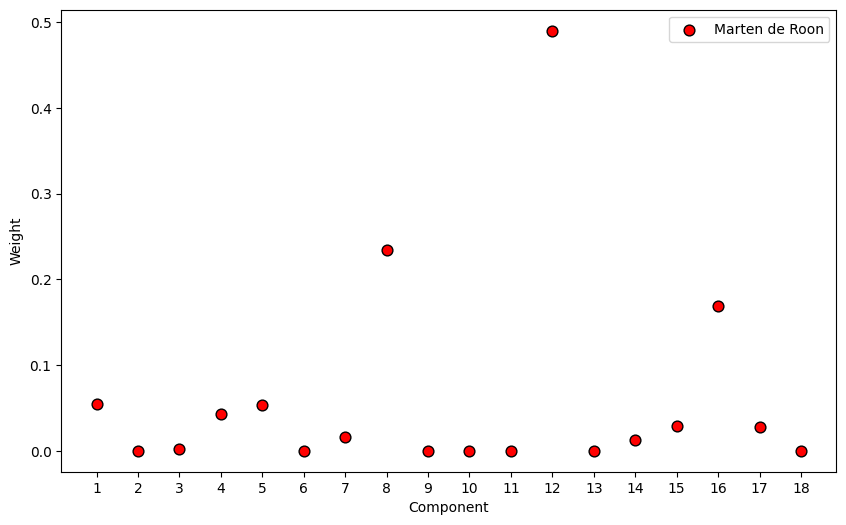

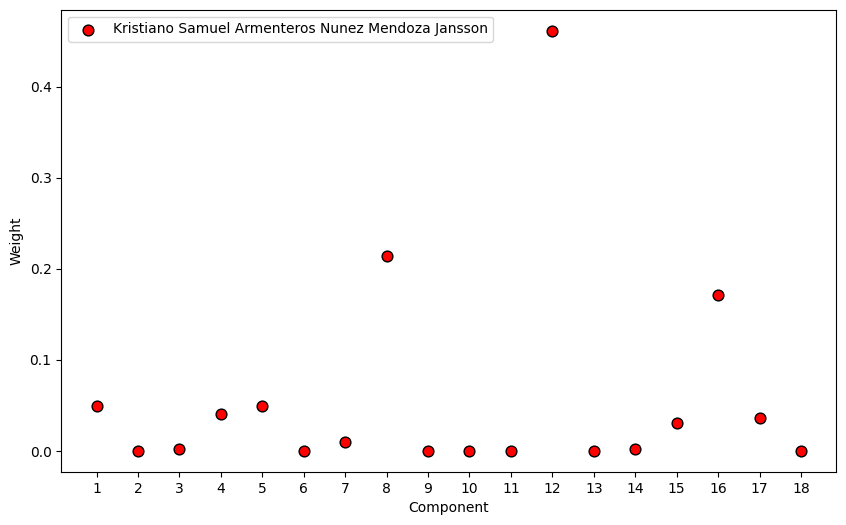

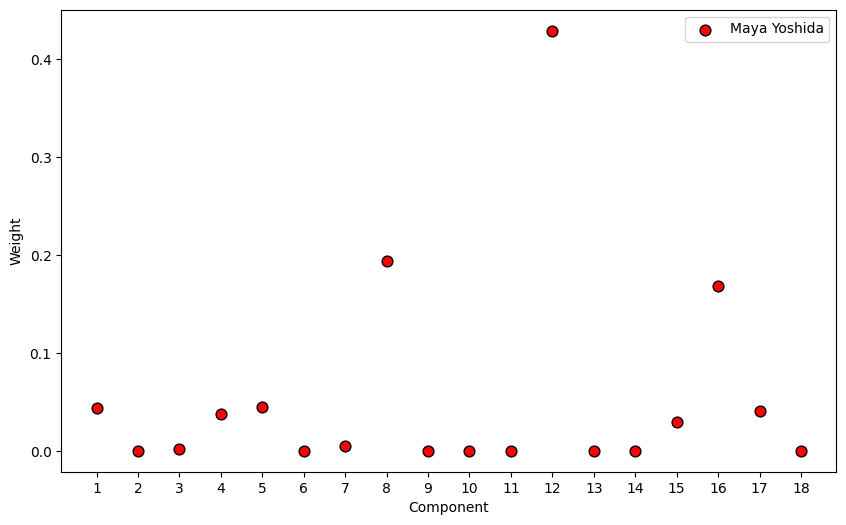

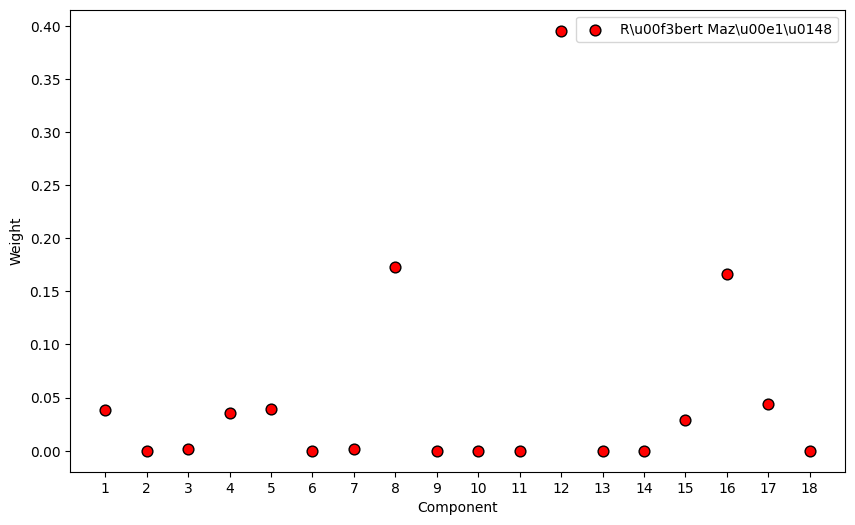

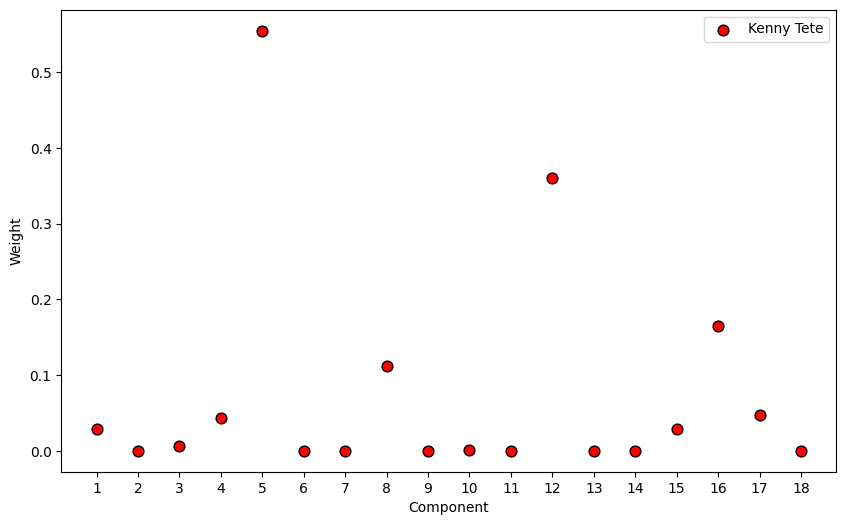

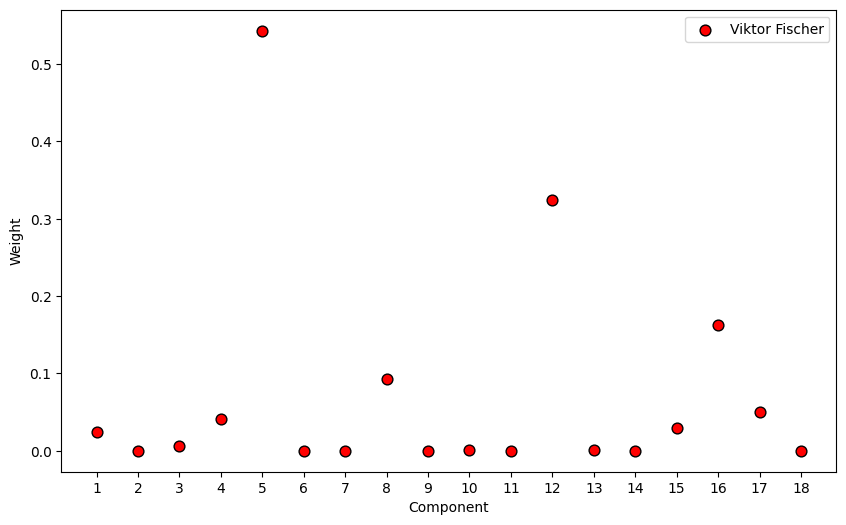

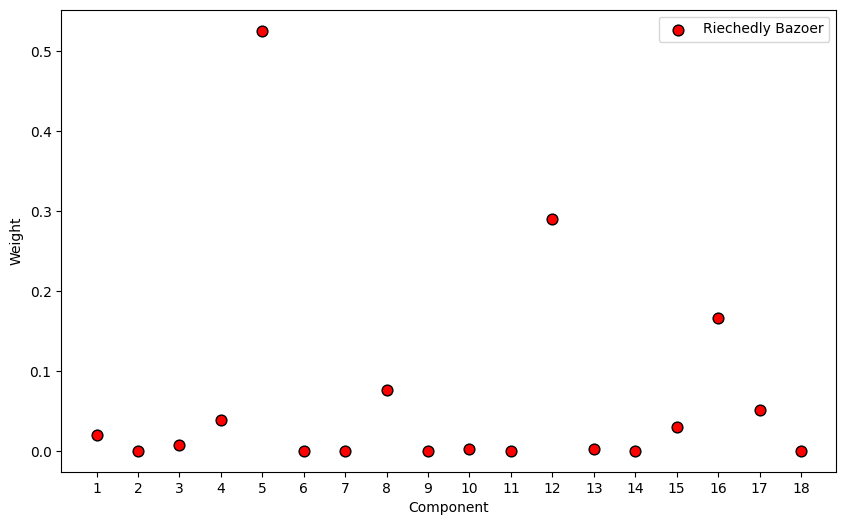

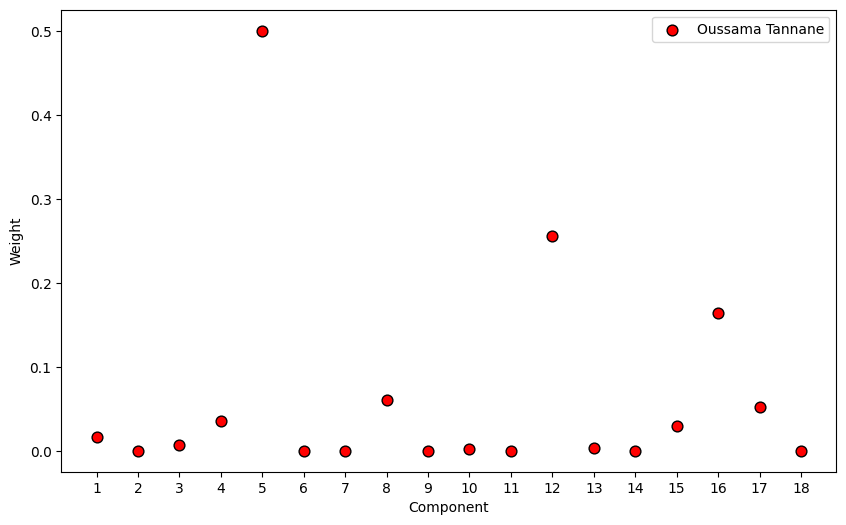

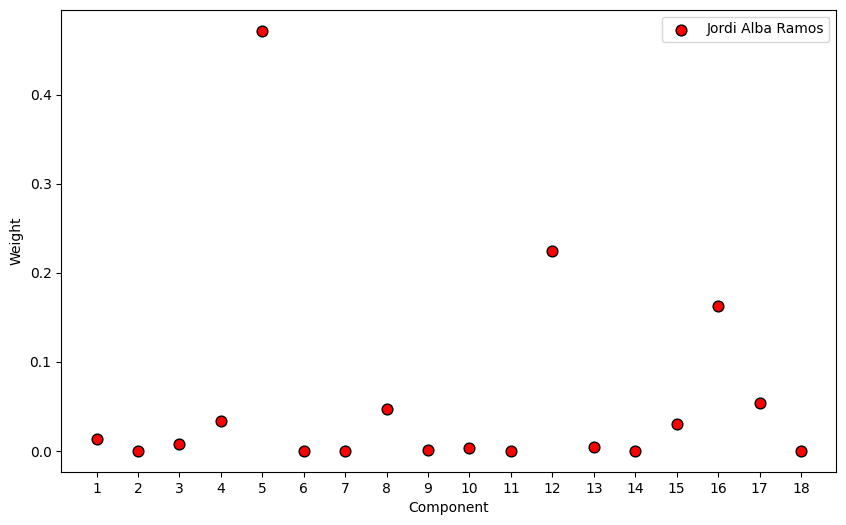

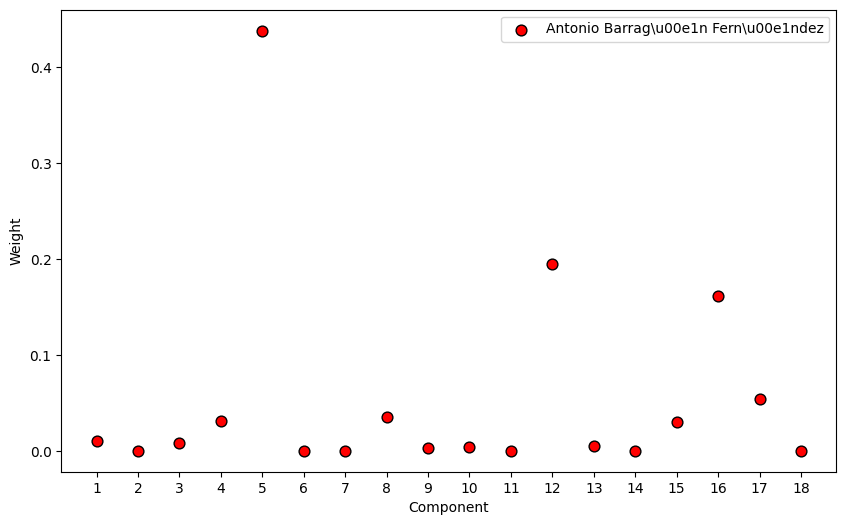

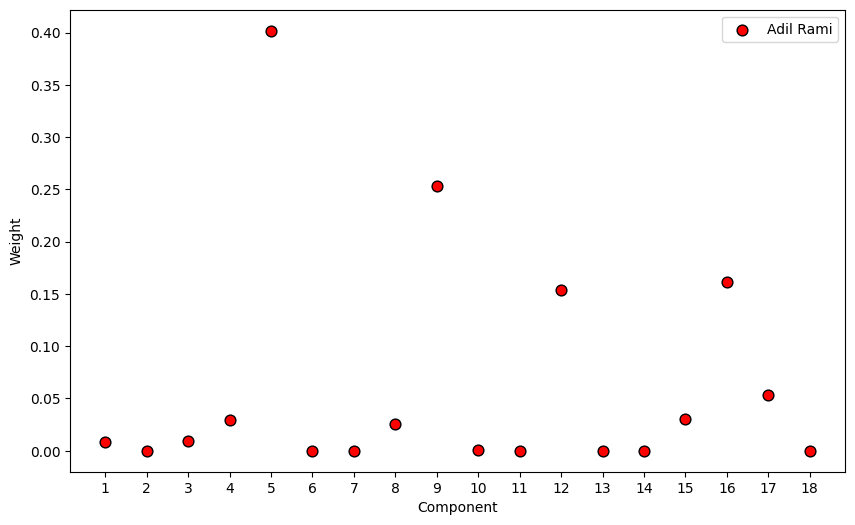

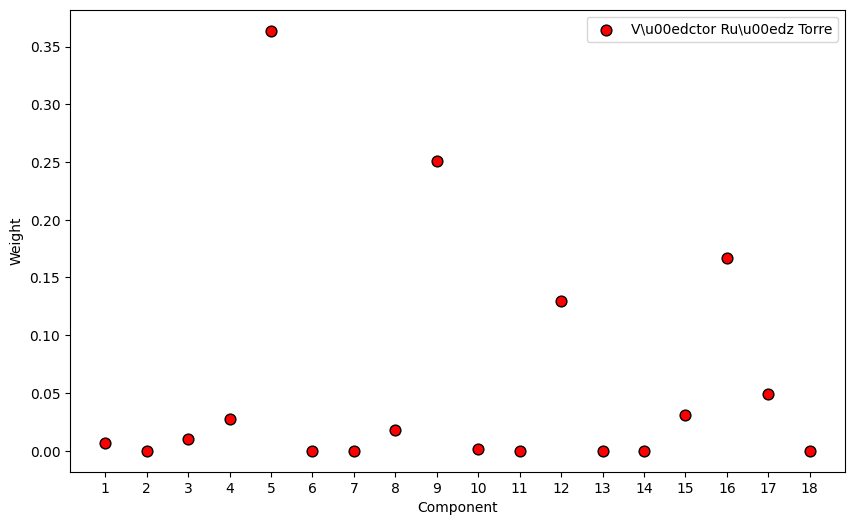

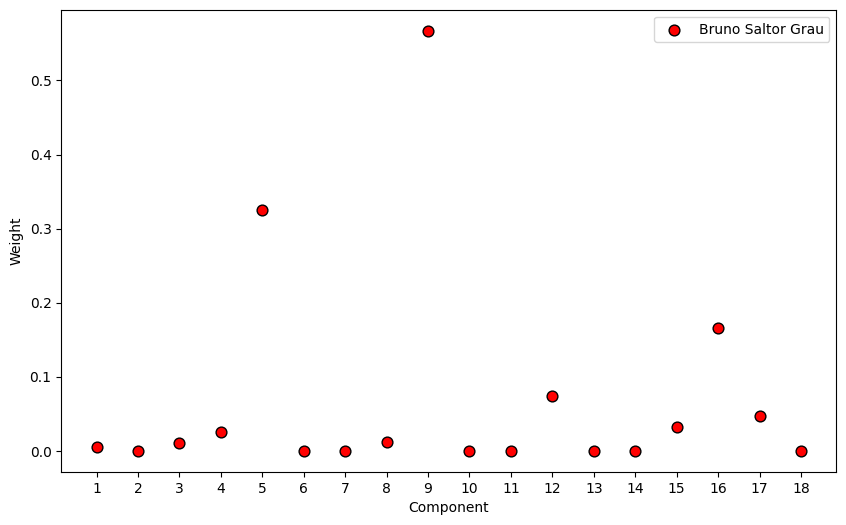

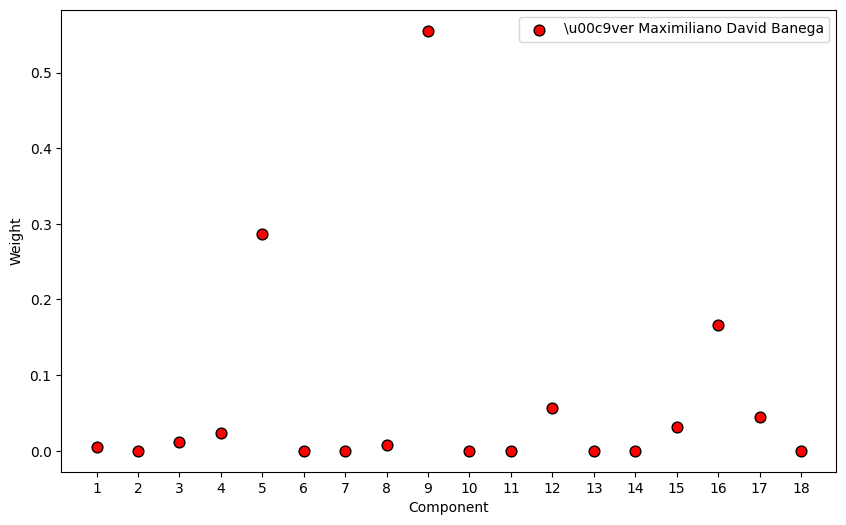

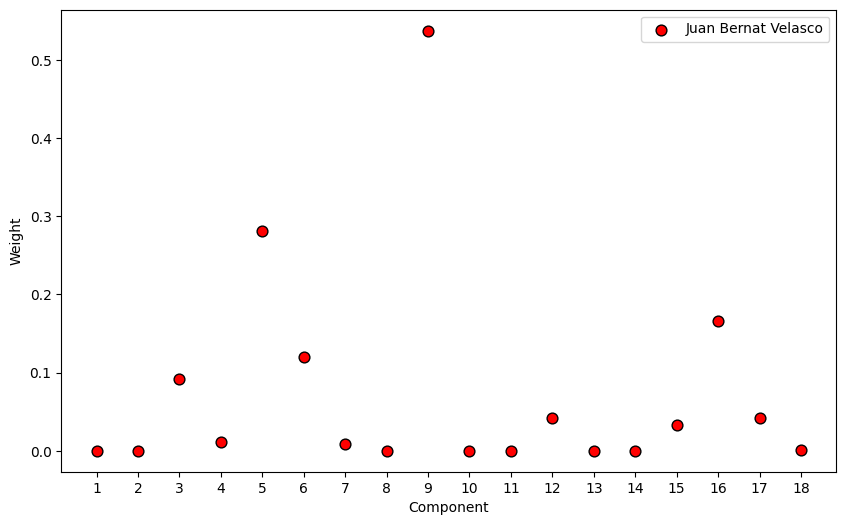

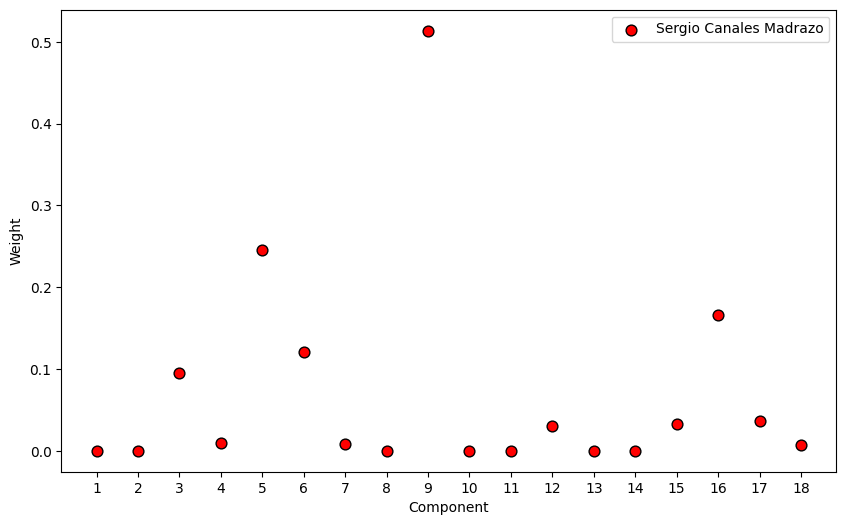

In [18]:
k_components = [_ for _ in range(1, 19)]
for num_plots, (playerID, components) in enumerate(player_to_vector.items()):
    name = '' 
    if playerID in playersID_to_name: 
        if len(components) == 18: 
            name = playersID_to_name[playerID]
            plt.figure(figsize=(10, 6))
            plt.xlabel('Component')
            plt.ylabel('Weight')
            plt.scatter(k_components,
                        components,
                        color='red',
                        edgecolors='black',
                        s=60,
                        label=name)
            plt.xticks(k_components) 
            plt.legend()
    if num_plots > 60:
        break